## **[Note]** In this file, you have 3 tasks to complete.

In Project 1, you will learn how to use CNNs for Chinese character recognition. In Project 2, you will use RNNs for text sentiment analysis.


# Project 1 : Chinese Character OCR Recognition Using CNN

Chinese characters, as symbols of the long history and rich culture of China, embody profound national sentiment and wisdom. From the evolution of oracle bone script to simplified characters, Chinese characters have not only been essential tools for recording history and conveying ideas but have also served as a bridge for communication and unity among various ethnic groups. In modern society, Chinese characters remain core elements in fields such as education, technology, and cultural transmission. However, with the rapid advancement of information technology, a significant amount of Chinese content still exists in paper or image formats, posing numerous challenges for organization, storage, and sharing.

In this context, OCR (Optical Character Recognition) technology plays a particularly important role. OCR technology can accurately recognize Chinese characters from images or paper documents and convert them into digital text, enabling efficient retrieval, editing, and archiving of Chinese materials. This not only facilitates document management for individuals and businesses but also creates new possibilities for the digital preservation and cultural dissemination of Chinese characters. Furthermore, OCR technology is widely applied in fields such as education, archival management, and historical document restoration, aiding in the preservation and innovation of traditional culture. Therefore, in today’s information society, OCR technology is crucial for the digitization of Chinese characters, providing strong technical support for the continuation and dissemination of Chinese culture.

In this assignment, we will apply the knowledge learned to create a simple Chinese OCR system. Through this project, we aim to deepen our understanding of OCR technology and explore its practical applications in the digital processing of Chinese characters.

## System Composition Introduction

Our system is composed of two main components to achieve basic Chinese OCR functionality:：

The first part is a Yolo model used for detecting the position of text within images. The Yolo model quickly and accurately locates text regions within an image, facilitating subsequent character recognition operations. To simplify project implementation, a pre-trained Yolo model is provided, eliminating the need for retraining; this model can directly be used to detect text locations within images.

The second part involves a CNN-based character recognition model designed to identify the content of individual characters. For this section, you can either construct a custom convolutional module to build a recognition model or directly use existing convolutional architectures such as ResNet or MobileNet, known for their strong feature extraction and recognition capabilities. Using this character recognition model, we can sequentially identify the text regions located by Yolo into specific Chinese characters, achieving comprehensive text extraction from images.

In [1]:
import os
import requests

def download_github_dir(repo, path, local_dir):
    """
    repo: "username/repository"
    path: path inside repo ("" for root)
    local_dir: local download directory
    """
    url = f"https://api.github.com/repos/{repo}/contents/{path}"
    r = requests.get(url).json()

    os.makedirs(local_dir, exist_ok=True)

    for item in r:
        item_path = item["path"]
        if item["type"] == "file":
            print("Downloading file:", item_path)
            download_url = item["download_url"]
            # 直接从路径中提取文件名，不保留MLhomework文件夹结构
            local_path = os.path.join(local_dir, os.path.basename(item_path))
            # 使用requests下载文件，而不是wget
            file_data = requests.get(download_url).content
            with open(local_path, 'wb') as f:
                f.write(file_data)

        elif item["type"] == "dir":
            # 递归下载子文件夹，但跳过MLhomework文件夹本身
            if path == "" and item["name"] == "MLhomework":
                # 如果是MLhomework文件夹，进入但不创建同名文件夹
                print("Entering MLhomework folder, contents will be extracted directly to current directory")
                download_github_dir(repo, item_path, local_dir)
            else:
                # 其他文件夹正常创建
                print("Entering folder:", item_path)
                download_github_dir(repo, item_path, os.path.join(local_dir, item["name"]))

# 使用方式
repo = "niddle0025-cyber/MLhomework"
download_github_dir(repo, "", ".")

Entering folder: Font


## Install the relevant dependencies

In [2]:
! pip install opencv-python -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install pillow -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install torch torchvision torchaudio -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install ultralytics -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install transformers -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install jieba matplotlib numpy pillow tqdm scikit-learn pandas -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## Character Recognition Model Based on CNN

### I. Text Detection Model

The text detection model is a Yolo model used to identify the position of text within images. The Yolo model can quickly and accurately locate text regions in an image, facilitating subsequent character recognition operations. For easier project implementation, a pre-trained Yolo model is provided, eliminating the need for retraining in this part.

Use the code below to test the detection results.


image 1/1 /content/IMG1.png: 352x832 239 chars, 79.0ms
Speed: 2.5ms preprocess, 79.0ms inference, 109.5ms postprocess per image at shape (1, 3, 352, 832)


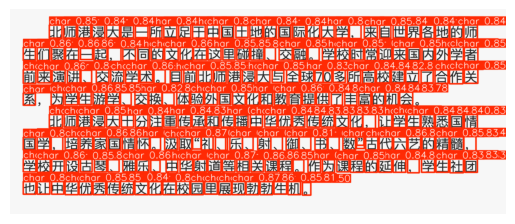

In [3]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
# Load a model
yolo = YOLO("best.pt")  # pretrained YOLO model

# Run batched inference on a list of images
results = yolo("IMG1.png")  # return a list of Results objects


for result in results:
    plt.imshow(result.plot())  # Display the original image
    plt.axis("off")
    plt.show()

### II. Character Recognition Model

#### 1. Dataset Preparation

To complete our task, we need to obtain a dataset. We can achieve this by using Python to generate characters, allowing us to produce a large number of character image files.

Here are all the characters we need to generate.

In [4]:
labels = "账树并擦最仓莱桌蔑编锐柒畦汪苞舵秦便息饿；雏央偷母葱浙忱碾衅运辰忿魏豁嗓嘲吓货叫谒摧飘拖砚养亏咱倦砾夭摘坛琳铐拟谬书逻翅箍缝例丑好历溃依掠银稿惜霞椰尽仁蛮工稳互严礼葵暑倘保酒遭仇许做痪橡丝疮件穆败愤滤幅闻翻辅隙铲弦糙代赠殷锡租仙位鲸舷符橱酷猩汗氓挚地饵安阿样泄唬憔干贩屹曼芥姜捎疾纱拴羔桂帜8插凌驼统寻阁杉丐凡验鬓瘫惩虏毕日环趟瘟边惰测卢溺住劈蜗摊祠组木恤琉引疙旦晦射萌策昆犬推q脱预晚抵奉二中违萍瘤诚藕常烟萤菲涌攘吕贯劣俱势诞水余妖限肌美漂参宋昭达吆说蕊咐臀旅挟苹控均阐殴涝祷轨摩融聪速踪驴扩谅辉形颖蝗皱北壁勤肠域妹畏社芋摄南忌贴捣蛋鳄充逛箫遥衍豌尸异嚷狸俘核糯酥篡扒沸觉震跷妻践状弄沛迫瞬漱沐伶绘氯提纪疯记始沥锦农哮详乘残栈杜技音现扼谴碌税晕先辕屈卦刺〉吉楞辨别煮撕稚镣倡生t锋度撞徘敦券唆喇菜k俺盗酸梭恼叼肛轴河允咪穿耀芳菱悉画急矫版业嘶挫莹炼桐拘怔捐润进鸭肾埂胯芯双狰彰坦霸的挤馋滚铆膨，侯+要蟋隐修栋乙倾虫怪么亮矮串腔带呛淡培霹儡李宿眯她瓮夸哟扛谁氮搅迅辞空诫雹截映滴哪肉诲陈俐易耗茁搀械砖容泌泡癌兽心剂首岛灰憋桶添澜把巾斗壳众卓益莉）传抹葫遂防译杂侧烛煤岁哑煞揭言分给向岖痘颗谚咒宠宅筒殃雀锉箩荒宛畔壹醇睦筐源蹭坞百但薪轿击喝厂姥牍花渡赴显酵诊泳贱络恐杠梅盟铃擎苦旷《半窒捡漠奢侵牺棠挣己丙刊混确胡准腾毫悔云蔬枯师远钞搭史早量恕祈英鸦呼家敢武乍腮坟陷悬思秃爬楔瞻米叮殖皇坏浆狈濒多锈享窝剃甫畜汁腰器饰拄殊搏川宽蓄撮公轩钉侣纽屏竣爸淌鸳摇崖蛔蟥敏绎缀逗扶茅乳肢蕴彻般节晶恬民p秩瞭巡志果系婴惹簇恶绒操茂览追吁召疑流袋直包肿玫味幽垒昨构超古呀竞顾赚钓咕e欠凹绕咏探腿覆波抒未骄狼性破乔鞋忆听竿掸普顿者句立兑榕将碱脆钝哥定拗冰韵璧淫挺兴讨查同窜秽如利敛叙跋虱汛蝇种捧莺纫歉卵权矩缰境缨睬展仲肯悼套浑铅评妈谍致傀妒跳阵拣糖兰陆疗床晰髓膝妙具市毯赁驾痴伤皿眨踊模委较涂暂攻等制喧触肖畴粹抗钻灿创崇抚批憨助赵拌卜期哲深孕貌豺哀谆番谋执搬淤响情待嗤马叶站烦茬什训洞庞廉窖歼谜蔽寨患盔肘阎幌遵弹翁名涮斋外涤掰刮椅昔晾采剑檬赋篱拾怖高励a率裸慎乓搞卑奠暮议媚末野括诽币乏布智佣邻紊彤长嘉粗葡酣欺虎锤衫数狞绩龄拱国倒得孽盘张讥回寝食饺刁艘炸秸寺其匈啦咬媳\\觅蘸辈惨储痊企躬蜒我胰缔士晃傅恒溢镶循淮针贷囱妨糊醉偎颂亲满惋冻盛所剧盐共蟀仿址寇撼石帝选前臣倚俏置挨雪俭笆淑转宫曲淋噪喘意侮罚啸遮〈蛛奖嚼良翩宏绳挥硬鞭卷搪惫累弛巨锻各怕咳坎昙烘窿死怒陌姿朽诅行褪烹了夺旨斧禀蚀z罐不诉印蝶爆单拯嚣焚黎徒鹊启雕次栖}奥诈蓖泥卡庶佩姨绣着蛾万慌赔嗦法j吞取氏肺庄哗闸宴放谢轰案供卧漫椭冤碎盖蚪缩欣甜堵顷蔚蚕炒皮肋爷骗戚每能喻请扎王潮护齐汞株颈勾阶亥售缅摸仆倔猜扬麦富羹资蓬浩丢你敌躯族营沧借辑身锄舟锹萎刻灸旁怎捌酱伦燃暗愧鸵垮匪6悯熄拂捺粪烧迈盏搂窃输上堤撤答畅昏懦之帽珍终溶吝朱光缕涧缺蓝陡投唱契蟆窑湿至词冀程春类员邀油猫阻浪笔持随本厌乎加车芦迷锯课冠升嫁栏质拦消瀑舱垫症琢榛橙叉饮郑冷蝎作算仰尖买幸娜披琅逸瑟辜知个优坯软g糜隘洋旧霎相摔竹h蝙讯饭愕谓蹋魔b矛斯滨凯阴约损蒸述压菊筋惑楼码片徽潭讹割台停胀务鳍菠馅九曙路哨誓式巴略棒履田敲匙播拳琴毡朋失坡州煌按吮染扯裕实辐邢餐啥岗闹题赏嗡梧抑-计瞎洽胚鉴耽皆填唇彪负柜救讳火澎i愉锣用植抽忙忧下默呕笑温夫蝉艇兢础槐胎熙几与“闰罪腥毛求蛉气尼鸥篇艺寄阅亿欲凰扔它螺娘铡松玻井泽峰淹揍唾适薄京有拼硫您邑跛扣秋唯诬协吱骂罩欧足晤辫纳教丹密塑巍冲亩朗缴脐婿县豪糕再扭鸠絮往炬照退瞄尚复s凸另役喳似念褥鹃墅点踏完绸跨蛙欢缸毅悲蜘鞍扁森雁掂起柬碟庆埋可夏铁维股拷舆禁秉刃池笤硝香滩沈林杏辖押仪科沫撇娄垂演垦栗吸俄肴鹏链牧傻峦豹浮鲜杖吟忠登袱馁鞠吊浸过尊步泼猬蝌剖伊阀躁臊咸圈旱梁然玩蜀佳金善反荠惠锭薇块拐端焕是联赤坠挎刹孵狱抖永配烁鸿呈嘱芝鸯遗贬霉掘祸也况内垄捂猎时镐瘩激殉谐土蚓字逮拨警柱笙明‘型凝趾溅漆喜角箭腌黄耘世袄削藏交吠财飞矾茸劲剔贼奋跪茵于蚯膀馒肮束纺堂久椎甚绪胸迹碳经褒受躺隅逃脏镇攀篙狭邦月陶需尝弥专炮惭争厅沮颊膊抓菌掷替慰靴里招象原秧d岳渊f贫衬造刚橄勇自#慢聚狐唠溉临都手孔继弱猛讶吴热练俯告宗血岭慕那梗炕脑恳泛瓜幕含湖繁董间喉廓氢开年揖渣兜苟表浦砌癣童磷声产玄椿隔嫌揩攒隆坐簿胧寞闺装僻烂屁蜈真蜻涡鲫骤娩疼赐逼鸟蚂钾篷颁予些湃侨跟喷郭屑讼捷梳卸柴尤栽撬熟捻沦闽抡圆称旋渔被汇估茧乒右糠儒曹框叹剪示避除徙面屡寓司檩鳞蹄窥吗惶学派频铣虑总虾兄责呜免倍勿七瓢险递叔恍十斟雇叨晋铺条鹅灌越衷换揽牛楷吐申天迁唉三队谈彬贺枉栅丁蜓喂禽泪贮债轻力戏征熏全伪辣镰铜懒脊炭愚锌螃舅淀去戴伍猴及号耻呆职牡沉宜颜份鹤革肩惯纯穗凤斥究镊歇汰贝薯朦露耐茫滓浓2雾铝接座秀库禾蜡榆颠吵灵拢焙昌蒋物翼袒鹉才没侥入男枣丰西精衔奔津沪医陪掉痰」n四宁肚雨胁憎躏躲额差梨膘棱闲槽毙沃惦茶文锰打函盅圾注杭%勃撩缓祭鲤猖佑塞邓柔掏潜梯绑姓碰旬赦蚊目恨翎补妓筑少鼓话导坑匕肪襟嘀痛球匠夷奶薛戳艰狡仅成捅庙瘦俗须涵考腕叭逞蔓宰军备萄闪宝姑圣裤疟{见x掌问希恭道贾介判乐收捍谷囤钦醒誊蜂唁捏捉沙宾假涩支吩封y隧缭党盹亦忽榔认青服掀苛移吭俩潦厉局初街磕纬误捞蒲紧散梦管庭铭苗拥帘友斤仗凛穷荷妆墩盼材勋键绊壕癞织山骆耕婶霍帖耍访简蛤奇腺突湘鸡r裆托骏堡段9牵匀否叛脸秫崔坷尔洼蚜翰口蚌昵蹂擅藤辛弓朝愈郊塌l到：坪1刑姻振伏料誉衣曾窘豫垃黍连仍尾赛鹿惕龙剥枝谤落饥屉拧骑辽跺范款婆洒靶稀感岂脖群撵游渴焦顶醋腐、庐整兼崎桑哼卫止嘹幔机熊绿闷官忘窍基绅灶呻一特踢宵两贞祝格哺焰幻=雅胳狮舍胖馍吃诱届摆撑尘厦旭邮婉萧羊虹图门缚嘴芹燥以建滞钳宪洪鸣牌厘俊颤粘涨人毁姐部尿袖趋衡墨署吻廊绽甥迟签战僚赃囊厚风班杆怠辱3积户菇芙途贤洗雄棉胞玷笋藐肆掖！怯箕滑正挖蒙购赫隶污城轧快新拭奄舰膳匣办秆白喊兔敷荣灾检关背弟今讽凳拇嘿碉剩增毒御他酗姊静规液鹰删钙来为钧校峻脯凑钟炉蹬抱慧更妇区监奕伙吹鹦赌们揣兵底帮玉爪奏拜呢错磁素靖熬劝笼虽乾授柑私延纹罢送甘榜折改绷销妄漾峭慨唤裳盲歌命诗憾蚤偏苫砂票稼陋舀腊耸奴凶粤逆疏鱼啰承横怀幢舌贵琼檀察沼枷歹谊魄v锚蛀调赊瓣爵剿头而诀怨梆费坊缎晒粟夕当缆冗堕澳千驻船莽爱遣扑店帆报信脓痒害必棋无侄褂珊斜尉耿壮逝会悟绢桅哈凫萨习列叁聋劳啤碴汽弃蠢犀迄非蕉诸矢哩兆牢洛绰比荸樱杈厨4疚钢踱女蜜挪孝园帅付影冶粒勉父还哆勺只奸太孙渠瞧徐泣写抄肝悄嗅因耳o檐乱帕指烫沟岸厢恢傲呵蚣拉榴窗帐呐佃匿绍附瓤蒿就飒订熔驮罗刨功审睛揉层羞姚汉鼻苔赖炫饶滥泰砰赂疤叽伞稽哄淘w舔蓉爽炊贸靠孟效册获谱康驹侠暇u咽墙裂揪跑蝴裁腻丧决眉伸铛蒜草啡药像镜副惧政伴冯悦螟老虐守柏障缠绝祖擒杯周疹距贰纵走扮勒集麸谭艾韭重枢芍伟低棵眶愿嫉邪漓锁姆璃舶磅搁驳？让逊樟嗜籍崩变夹捶骚帚巢蚁透遍漩态聂候催神撒褐危活庸丽娇疫广掩威斑腋这矿芜钠咨袜挑很领侈元咆蛇赡讲澄酪析疲级衙靡滔嫩标废韧梢痕垛搜柿困殿狗寂黑主甲逢沾盯瞪体寒卤锥跌综柄典雷咖卿硼平幼挂泉。荐昼谎左弧颇渐僵轮啃缤拙踩彭东通胜筏譬占榄切冈芒在闯舒眠肄汤仑馆握由饲聘昂猪粱悴德饼骇钱戒竖断赘纷刷悍降牙驰理胆猿凭发楣客郁蠕猾净询亭瓦寥祥堰碘线近湾航塔澈晓枪桃乖荧m叠脉蹦鄙碧偶钥挽却价羡逐篓塘弊视泞玛潘狠嘁冕使独茄挠商妥秕席纤嗽甸极措凿钩担岔怜翠茎细且举撰舞小根懈晌努爹抛豆坝克架任葬港辙瘸皂搔玲腹围哎陕趣衩棘鼎丘敬溪抠档存”绞杨吼孤暖栓纸冒棚陨搓漏稻&柳牲昧解清袭嫡酌糟筹红筷耙簸室固盒罕涣噩茉眷府膜砍谨啄钮督懂翘旺值项灼苇畸蔼辩渗烤菩碗电纠痢后冬霜盈*犁难孩荞侦氧骨续蟹荡施藻则卖焊烈棕眼瑰矗语摹臭诺观既狂酿陵吨唧僧娶归酝擂驱网芭该八溯返恰减趴够休瓷闭泻佛涉胶鼠涯伯甩瑞某桩疆稍拆惊诵苍结品巷逾博翔概慈迎歪斩袁玖君即此瘾崭洁泊乃刽色芬岩铸找若彼睡埃涎描粥旗录沿留属淆济赎泵遇壶荆丸扰弯慷浴扫咙刘抢晴劫拍援抬睹令掺膏氨朴恋筝坤贡@榨子哭碑蛆锨挡硅愁虚恃强裹庇雳炎屿樊羽巧场著凉乡脚橘艳伺偿燕房蔗诡寸序宣乌蛹界磨驯拒赶晨吧阳巫窄苏笨扇五楚滋郎捆秘龟秤识桥病福离箱动戈柠棺齿秒枕想笛嵌燎奈犹渤肥捕望亚堆团啊c嚎合献馏对缘纲臂顽胃桦试微荔浊蒂拓研索零（棍涛氛拔遏珠凄粉脂海顺窟匆仔季礁悠魁驶脾茴篮祟趁携丈迂阔烙镀鲁盆赢麻阱埠庵枫乞萝屯荚术瞒廷衰蹲袍筛第宦杰莫华板鳖星裙涕5壤杀已或短肤勘敞澡尺据竭儿页酬荤堪砸婚丛读淳浇》夜义硕溜夯际坚巩村忍寿方匾】颓午贿治臼痹择锅大犯应谦排椒化侍贪囚0朵划故蘑墓蹈院桨载枚圃芽碍从睁省江伐彩【盾设亡瓶景居掐琐六魂促卒蔫穴暴论厕健「媒鬼辆紫娃饱屎宇刀看垢跃何募膛灭蜕瘪浅和瞳证灯懊渺谣汹又径骡唐蝠寡律辟章嫂籽屋育啼事颅粮7蕾雌出处莲恩肃韩峡葛煎吏徊拿绵嬉释傍黔鸽屠沽咧娱竟歧匹稠扳洲赞宙聊QWERTYUIOPASDFGHJKLZXCVBNM"

We can use the len method to get the character count.

In [5]:
print("Length of labels is :",len(labels))

Length of labels is : 3593


We use the following code to generate samples.

**[Note]** You will need approximately 6GB of space to store these samples.

In [6]:
# @title
import os
import random
import numpy as np
import cv2
import time
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from multiprocessing import Process, Value, current_process, Lock

# Import necessary libraries

# Define a function to generate a sample image with a character using a given font
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random
import cv2

def generate_sample(char, font_path):
    image_size = (64, 64)  # Set the image size to 64x64 pixels
    background_color = (255, 255, 255)  # White background color

    # Create a new image with the specified size and background color
    image = Image.new('RGB', image_size, background_color)
    draw = ImageDraw.Draw(image)  # Create a drawing object for the image

    # Dynamically adjust the font size to fit the character within the image
    max_font_size = 48
    min_font_size = 10
    font_size = max_font_size
    font = ImageFont.truetype(font_path, font_size)

    # Gradually reduce the font size until the text fits within the image
    while font_size >= min_font_size:
        bbox = draw.textbbox((0, 0), char, font=font)  # Get the bounding box of the text
        text_width = bbox[2] - bbox[0]  # Calculate text width
        text_height = bbox[3] - bbox[1]  # Calculate text height

        if text_width <= image_size[0] and text_height <= image_size[1]:  # Check if text fits within image
            break
        font_size -= 1  # Decrease font size
        font = ImageFont.truetype(font_path, font_size)  # Update the font with the new size

    # Check if the final font size fits, if not return an empty image to avoid errors
    if font_size < min_font_size:
        print("Character cannot fit into the image size")
        return image  # Return a blank image if the character cannot fit

    # Calculate the centered position for the text
    position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)
    draw.text(position, char, fill=(0, 0, 0), font=font)  # Draw the character on the image

    # Convert the image to a NumPy array and add random noise
    image_np = np.array(image)
    noise_level = 10  # Set noise level
    noise = np.random.randint(-noise_level, noise_level, image_np.shape, dtype='int16')  # Generate noise
    noisy_image_np = np.clip(image_np + noise, 0, 255).astype('uint8')  # Add noise to the image and clip the values

    # Randomly apply erosion or dilation operation to the image
    kernel = np.ones((3, 3), np.uint8)  # Define a 3x3 kernel for morphology operations
    processed_image_np = noisy_image_np
    if random.random() < 0.5:  # Randomly decide whether to apply erosion
        processed_image_np = cv2.erode(noisy_image_np, kernel, iterations=1)

    # Convert the NumPy array back to an image
    processed_image = Image.fromarray(processed_image_np)
    if char not in '._＿':  # If character is not one of these, apply random rotation
        rotation_angle = random.uniform(-5, 5)  # Random rotation angle between -5 and 5 degrees
        processed_image = processed_image.rotate(rotation_angle, expand=False, fillcolor=background_color)  # Rotate image

    return processed_image  # Return the final processed image

# Function to determine if an image is blank (using grayscale variance method)
def is_blank_image(image, threshold=50):
    gray_image = np.array(image.convert('L'))  # Convert image to grayscale
    variance = gray_image.var()  # Calculate variance of the grayscale image
    return variance < threshold  # Return True if variance is below the threshold (indicating blank image)

# Define function to save generated sample image
def save_sample(image, label):
    folder_name = "./generate_data/" + label  # Define folder path for the label
    os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist
    file_count = len(os.listdir(folder_name))  # Count number of existing files in the folder
    file_name = f"{file_count}.png"  # Define the new file name
    file_path = os.path.join(folder_name, file_name)  # Get the complete file path
    image.save(file_path)  # Save the image to the specified path

# Function to check if a character is supported by the font
def is_char_supported(char, font_path, font_size=48):
    try:
        font = ImageFont.truetype(font_path, font_size)  # Load the font with the given size
        # Attempt to get character bounding box to check if the font supports the character
        if font.getbbox(char):
            return True  # If bounding box is found, character is supported
    except OSError:
        pass  # Handle font loading error
    return False  # Return False if the character is not supported

# Function to process a subset of labels
def process_labels(labels, font_files, count, progress, lock):
    for char in labels:
        font_paths = random.choices(font_files, k=count)  # Randomly choose fonts from the font files
        for font_path in font_paths:
            # Check if the font supports the current character
            if not is_char_supported(char, font_path):
                print(f"Font {font_path} does NOT support character '{char}'")
                continue  # Skip unsupported fonts

            tryCnt = 0  # Initialize retry counter
            image = generate_sample(char, font_path)  # Generate a sample image
            while is_blank_image(image) and tryCnt <= 10:  # Retry if image is blank
                tryCnt += 1
                # Randomly select a new font that supports the character
                newfont = random.choice([f for f in font_files if is_char_supported(char, f)])
                image = generate_sample(char, newfont)  # Generate image with the new font
            if tryCnt > 9:  # Stop retrying if limit exceeded
                continue
            save_sample(image, char)  # Save the generated image

            with lock:  # Lock to update shared progress safely in multiprocessing
                progress.value += 1  # Increment progress


We use multiprocessing for generation; it may take you half an hour to an hour to generate the samples.

---

## Task 1 (10 Pts)

**Problem Description**:

In this task, you will implement a multi-process dataset generator. We have provided you with the `process_labels` function, which generates samples based on labels and font files. Follow the requirements and hints below to complete the code.

**Task Requirements**:

1. **Font File Reading**(1 Pt):
   - Define the variable `font_directory` as the font file storage path `./Font`. Read all `.ttf` and `.ttc` files from this directory and store their paths in the `font_files` list.

2. **Calculate Total Sample Count**(1 Pt):
   - Set the variable `count` to specify the number of samples to generate per label, with a generation quantity of 100 samples per label.
   - The `labels` list, which contains all labels, has been previously defined. Calculate the total number of samples, `total_samples`.

3. **Shared Progress Counter and Lock**(2 Pts):
   - Create a multi-process shared variable `progress` (using `Value`) to track the total number of generated samples.
   - Create a `Lock` object to manage access to shared resources.

4. **Label Splitting**(1 Pt):
   - Define the variable `num_processes` to indicate the number of processes. Set it to the number of cores on your processor.
   - Split `labels` into `num_processes` chunks so that each process handles one chunk of labels.

5. **Multi-process Implementation**(2 Pts):
   - Create a `Process` instance for each chunk of labels and call the `process_labels` function to handle that chunk. Pass `font_files`, `count`, `progress`, and `lock` as arguments to `process_labels`.
   - Start each process so they run in parallel.

6. **Progress Bar Implementation**(1 Pt):
   - Use `tqdm` to display the total progress of sample generation, updating once per second.
   - In a loop, check the status of each process and use the `progress` variable to update the `tqdm` progress bar until all processes finish.

7. **Wait for Processes to Finish**(1 Pt):
   - Use `join` to ensure that all processes complete before the code continues executing.

8. **Completion Message**(1 Pt):
   - After all processes are complete, print “All samples generated”.

**Hints**:

- Ensure that you pass the correct parameters to `process_labels` in each process.
- Use `lock` to ensure thread-safe progress updates.
- Try debugging and running the code to ensure that the progress bar and parallel processes display and execute correctly.

In [7]:
# @title
# Multi-process Data Generation Script (Colab/Linux compatible)
import os
import glob
import time
from multiprocessing import Process, Value, Lock
from tqdm import tqdm

# -----------------------------
# Import process_labels function (should be defined in worker.py)
# -----------------------------

try:
    process_labels  # Check if function exists in current namespace
except NameError:
    # Fallback stub for testing (replace with actual import in production)
    def process_labels(labels_chunk, font_files, count, progress, lock):
        # Example stub: simulate data generation with sleep
        for lbl in labels_chunk:
            for i in range(count):
                time.sleep(0.01)  # Simulate generation time
                with lock:
                    progress.value += 1

# -----------------------------
# 1) Font file reading
# -----------------------------
font_directory = "./Font"
if not os.path.isdir(font_directory):
    print(f"Warning: Font directory '{font_directory}' not found.")

font_files = sorted(glob.glob(os.path.join(font_directory, "*.ttf")) +
                    glob.glob(os.path.join(font_directory, "*.ttc")))
print(f"Found {len(font_files)} font files.")

# -----------------------------
# 2) Labels and count configuration
# -----------------------------
try:
    labels  # Use existing labels if defined
except NameError:
    # Fallback example labels
    labels = [chr(i) for i in range(97, 97+26)]  # a..z example
    print("Note: Using example labels. Replace with actual labels from assignment.")

count = 100  # Samples per label
total_samples = len(labels) * count
print(f"Total labels: {len(labels)}, samples per label: {count}, total samples: {total_samples}")

# -----------------------------
# 3) Shared progress counter and lock
# -----------------------------
progress = Value('i', 0)  # Integer shared variable
lock = Lock()

# -----------------------------
# 4) Split labels into chunks for multiprocessing
# -----------------------------
num_processes = os.cpu_count() or 1
print(f"Using {num_processes} processes")

def chunk_list(lst, n):
    """Split list into n chunks with balanced sizes"""
    k, m = divmod(len(lst), n)
    chunks = []
    start = 0
    for i in range(n):
        size = k + (1 if i < m else 0)
        chunks.append(lst[start:start+size])
        start += size
    return chunks

label_chunks = chunk_list(labels, num_processes)
label_chunks = [c for c in label_chunks if c]  # Remove empty chunks

# -----------------------------
# 5) Start child processes
# -----------------------------
processes = []
for chunk in label_chunks:
    p = Process(target=process_labels, args=(chunk, font_files, count, progress, lock))
    processes.append(p)
    p.start()

# -----------------------------
# 6) Progress monitoring
# -----------------------------
with tqdm(total=total_samples, desc="Generating samples") as pbar:
    prev = 0
    while any(p.is_alive() for p in processes):
        with lock:
            cur = int(progress.value)
        delta = cur - prev
        if delta > 0:
            pbar.update(delta)
            prev = cur
        time.sleep(1.0)  # Update interval
    with lock:
        cur = int(progress.value)
    if cur - prev > 0:
        pbar.update(cur - prev)

# -----------------------------
# 7) Wait for processes to complete
# -----------------------------
for p in processes:
    p.join()

print("All samples generated")

Found 10 font files.
Total labels: 3593, samples per label: 100, total samples: 359300
Using 12 processes


Generating samples: 100%|██████████| 359300/359300 [02:20<00:00, 2559.96it/s]

All samples generated


We use the following code to view the generated files.

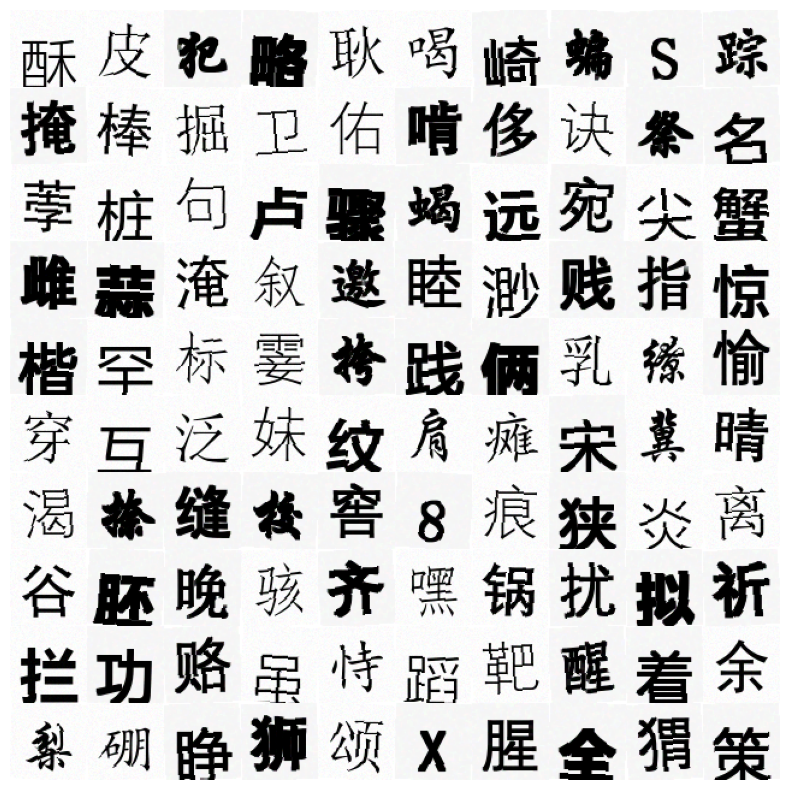

In [8]:
import os
import random
from PIL import Image

# Define a function to generate an overview image
def create_random_overview_image(data_dir, grid_size=(10, 10), image_size=(64, 64)):
    # Create a blank canvas
    canvas_size = (grid_size[0] * image_size[0], grid_size[1] * image_size[1])
    overview_image = Image.new('RGB', canvas_size, (255, 255, 255))

    # Get all character folders
    labels = os.listdir(data_dir)
    random.shuffle(labels)  # Randomly shuffle the character order
    label_count = 0

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            if label_count < len(labels):
                # Randomly select an image file from the current character folder
                label = labels[label_count]
                label_path = os.path.join(data_dir, label)
                images = os.listdir(label_path)
                if images:
                    image_path = os.path.join(label_path, random.choice(images))
                    image = Image.open(image_path).resize(image_size)
                    # Paste the image at the corresponding position on the canvas
                    overview_image.paste(image, (col * image_size[0], row * image_size[1]))
                    label_count += 1
            else:
                break

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(overview_image)
    plt.axis('off')
    plt.show()

# Example usage
data_dir = "./generate_data"  # Path to the folder containing generated images
create_random_overview_image(data_dir)


---

#### 2. Train the model

## Task 2 (40 Pts)

**Task Requirements**:

1. **Load and Split Dataset** (3 Pts)  
   - Use the `ImageFolder` class to load the image dataset located in "./generate_data", and split it into training and validation sets in an 8:2 ratio by indexing.

2. **Data Augmentation and Preprocessing** (4 Pts)  
   - Define data augmentation and preprocessing steps with `transforms.Compose`, including resizing images, converting them to tensors, and normalizing.

3. **Define Model Architecture** (8 Pts)  
   - Build the convolutional neural network model architecture in the `Model` class, designing convolutional layers, pooling layers, and fully connected layers suitable for image classification. Ensure the output layer’s dimension matches the number of classes in the dataset. You can use some ready-made convolutional frameworks, such as ResNet and VGG, or define your own model architecture.

4. **Set Loss Function and Optimizer** (3 Pts)  
   - Use `CrossEntropyLoss` as the loss function and apply the Adam optimizer to optimize model parameters with the specified learning rate.

5. **Training Loop** (5 Pts)  
   - Set the number of training epochs, put the model in training mode, and for each batch, perform forward propagation, calculate loss, apply backpropagation, and update parameters. Display a progress bar with the current average loss.

6. **Validation Loop** (3 Pts)  
   - At the end of each training epoch, enter the validation phase. Switch the model to evaluation mode, calculate validation loss and accuracy by performing forward propagation and accuracy calculation.

7. **Output Training Results** (2 Pts)  
   - At the end of each epoch, print the training loss, validation loss, and validation accuracy to monitor the model's performance.

8. **Save Model** (2 Marks)  
   - After training is complete, save the trained model to a file for later use or further adjustments.

9. **Evaluate Accuracy and Optimize Hyperparameters** (10 Pts)  
   - After completing the model training, make every effort to improve the model's accuracy by tuning hyperparameters. Your score will be awarded based on the achieved accuracy according to the following criteria:
     - [60%,80%) accuracy: 5 points
     - [80%,90%) accuracy: 7 points
     - [90%,95%) accuracy: 8 points
     - [95%,99%) accuracy: 9 points
     -  99%+ accuracy: 10 points

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
from tqdm import tqdm
from torch.amp import GradScaler, autocast

###############################
# Safe Loader for Invalid Images
###############################
def safe_loader(path):
    try:
        img = Image.open(path)
        img.verify()                # verify file
        img = Image.open(path)      # reopen after verification
        return img.convert("RGB")
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

###########################################
# Residual Block (for ResNet-like backbone)
###########################################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Match dimension if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

###########################################
# Model Architecture (ResNet-like)
###########################################
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 128, blocks=2, stride=1)
        self.layer2 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        layers += [ResidualBlock(out_channels, out_channels) for _ in range(blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


###################################################
# 1. Load & Split Dataset (MEETS TASK REQUIREMENTS)
###################################################
data_dir = "./generate_data"

# Data augmentation + preprocessing (Task要求)
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full dataset
full_dataset = datasets.ImageFolder(
    data_dir,
    loader=safe_loader,
    transform=train_transform
)

# Remove invalid images
full_dataset.samples = [
    s for s in full_dataset.samples if s[0] is not None
]

# 8:2 split (Task要求)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Validation set uses different transform
val_dataset.dataset.transform = val_transform

###################################
# DataLoader
###################################
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

###################################
# 2. Define Model
###################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(full_dataset.classes)
model = ResNetModel(num_classes).to(device)

###################################
# 3. Loss & Optimizer
###################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
scaler = GradScaler()

###################################
# 4–6. Training + Validation Loop
###################################
num_epochs = 5  # ★
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast(device_type=device.type):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    ###################
    # Validation
    ###################
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total * 100

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    scheduler.step()

###########################
# 7. Save Model (state_dict)
###########################
torch.save(model.state_dict(), "model_task2.pth")
print("Model saved to model_task2.pth")


Epoch 1/5: 100%|██████████| 17965/17965 [03:41<00:00, 81.07it/s]


Epoch 1/5 | Train Loss: 3.6125 | Val Loss: 0.0693 | Val Acc: 97.96%


Epoch 2/5: 100%|██████████| 17965/17965 [03:36<00:00, 82.95it/s]


Epoch 2/5 | Train Loss: 0.1060 | Val Loss: 0.0111 | Val Acc: 99.63%


Epoch 3/5: 100%|██████████| 17965/17965 [03:42<00:00, 80.84it/s]


Epoch 3/5 | Train Loss: 0.0408 | Val Loss: 0.0065 | Val Acc: 99.78%


Epoch 4/5: 100%|██████████| 17965/17965 [03:40<00:00, 81.58it/s]


Epoch 4/5 | Train Loss: 0.0153 | Val Loss: 0.0038 | Val Acc: 99.86%


Epoch 5/5: 100%|██████████| 17965/17965 [03:38<00:00, 82.26it/s]


Epoch 5/5 | Train Loss: 0.0114 | Val Loss: 0.0033 | Val Acc: 99.90%
Model saved to model_task2.pth


---

### III. Fusion of Two Models

You can use the code below to test the result of merging the two models.


0: 832x832 239 chars, 4.0ms
1: 832x832 79 chars, 4.0ms
Speed: 3.2ms preprocess, 4.0ms inference, 1.1ms postprocess per image at shape (1, 3, 832, 832)


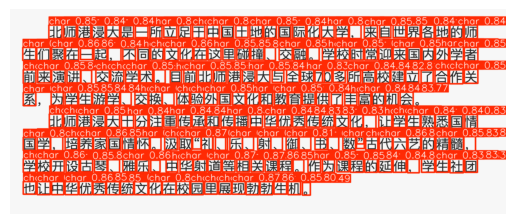

Result :
 北师港浸大是二所立足于中国土地的国际化大学：来自世界各地的师
生们聚在二起：不同的文化在这里碰撞-交融。学校时常迎来国内外学者
前来演讲s交流学术s目前北师港浸大与全球了O多所高校建立了合作关
系为学生游学-交换：体验外国文化和教育提供了丰富的机会
北师港浸大十分注重传承和传播中华优秀传统文化：让学生熟悉国情
国学：培养家国情怀s涩取吓礼s：乐s射s御s书-数””古代六艺的精髓：
学校开设古琴-雅乐-中华射道等相关课程s作为课程的延伸：学生社团
也让中华优秀传统文化在校园里展现勃勃生机a



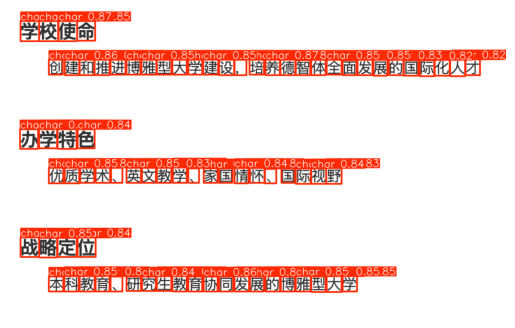

Result :
 学校使命
创建和推进博雅型大学建设：培养德智体全面发展的国际化人才
办学特色
优质学术：英文教学：家国情怀s国际视野
战略定位
本科教育s研究生教育协同发展的博雅型大学



In [14]:
from ultralytics import YOLO
from PIL import Image, ImageOps
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

#add something here!!
from torchvision import datasets, transforms

data_dir = "./generate_data"

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(data_dir, transform=transform)



# Load a YOLO model
yolo = YOLO("best.pt")  # pretrained YOLO model
image_path = ["IMG1.png","IMG2.png"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.save(model.state_dict(), "model_weights.pth")

# Preprocessing function to align with the ResNet model input
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match the expected input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Run inference and get the first result
results = yolo(image_path)

for index,result in enumerate(results):
    plt.imshow(result.plot())  # Display the original image with detections
    plt.axis("off")
    plt.show()

    # Extract detection boxes
    boxes = []
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        boxes.append(((x1, y1, x2, y2), box))

    # Sort boxes by their vertical position, grouping nearby boxes into lines
    line_threshold = 10  # Adjust this value based on text line spacing
    sorted_boxes = sorted(boxes, key=lambda b: (b[0][1], b[0][0]))

    # Group boxes by lines
    lines = []
    current_line = [sorted_boxes[0]]
    for i in range(1, len(sorted_boxes)):
        y_diff = abs(sorted_boxes[i][0][1] - current_line[-1][0][1])
        if y_diff < line_threshold:
            current_line.append(sorted_boxes[i])
        else:
            # Sort the current line horizontally
            lines.append(sorted(current_line, key=lambda b: b[0][0]))
            current_line = [sorted_boxes[i]]
    # Append the last line
    if current_line:
        lines.append(sorted(current_line, key=lambda b: b[0][0]))

    # Iterate over each line of detected boxes
    recognized_text = ""
    for line in lines:
        for box in line:
            x1, y1, x2, y2 = box[0]
            image = Image.open(image_path[index]).convert("RGB")

            # Crop the original image to get the detected region
            cropped_img = image.crop((x1, y1, x2, y2))

            # Calculate padding (20% of width and height)
            width, height = cropped_img.size
            padding_w, padding_h = int(width * 0.2), int(height * 0.2)

            # Add padding to the image
            padded_img = ImageOps.expand(cropped_img, border=(padding_w, padding_h), fill=(255, 255, 255))

            # Transform the padded image for ResNet input
            input_tensor = transform(padded_img).unsqueeze(0).to(device)

            # Character recognition with ResNet model
            with torch.no_grad():
                output = model(input_tensor)
                predicted_class = output.argmax(1).item()
                recognized_char = dataset.classes[predicted_class]
                recognized_text += recognized_char
        recognized_text += "\n"  # Add space between lines for readability

    # Output the recognized text
    print(f"Result :\n {recognized_text}")


#

# Project 2 :RNN Text Sentiment Recognition

The Recurrent Neural Network (RNN) is a deep learning model well-suited for processing sequential data and performs exceptionally in text sentiment recognition tasks. Its recurrent structure allows information to flow through the network, enabling it to effectively capture the relationships between preceding and following words in a sentence, as well as contextual information—ideal for handling the sequential nature of natural language. RNNs process text word by word, updating the hidden layer’s state to retain previous content, which influences subsequent words and helps the model understand the overall sentiment of the sentence.

In this assignment, we will complete the development and evaluation of an RNN-based text sentiment recognition model. First, we will prepare for model input by performing tokenization and vectorization. Then, we’ll build a sentiment recognition model using RNN to allow the model to learn sentiment features from sequential data inputs. Next, we’ll train the model and optimize hyperparameters to enhance its performance on the test set.

Let’s start by importing the necessary libraries and checking for available devices.

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import jieba
import pandas as pd
# Check for available CUDA device(s)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


Using device: cuda


You need to set some hyperparameters.

In [16]:
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
EPOCHS = 20

We also need to load and define the dataset class, then load the data.

In [17]:
# @title
# Dataset example, assuming a format similar to the previous IMDB format
class ChineseDataset(Dataset):
    def __init__(self, file_path):
        # Initialize an empty list to store data
        self.data = []

        # Open the first file and read line by line
        with open(file_path[0], "r", encoding="utf-8") as f:
            for line in f:
                # Split each line by tab to separate label and text
                label, text = line.strip().split('\t')

                # Skip header row if it exists
                if label == 'label':
                    continue
                # Append (label, text) tuple to the data list
                self.data.append((int(label), text))

        # If there’s a second file, load it as well
        if len(file_path) > 1:
            data = pd.read_csv(file_path[1], skiprows=1, sep=',', names=['label', 'review'], encoding='utf-8')

            # Iterate over label and review columns to add to data list
            for label, text in zip(data['label'].tolist(), data['review'].tolist()):
                if label == 'label':
                    continue
                self.data.append((int(label), text))

    # Return the length of the dataset
    def __len__(self):
        return len(self.data)

    # Return the item at the given index
    def __getitem__(self, idx):
        return self.data[idx]

# Load the data
train_data = ChineseDataset(["train.tsv", "weibo_senti_100k.csv"])  # Assuming there’s a train file
test_data = ChineseDataset(["test.tsv"])  # Assuming there’s a test file


We need to build the Jieba tokenizer and vocabulary.

In [18]:
# Tokenization and vocabulary
def chinese_tokenizer(text):
    # Use jieba to split Chinese text into tokens
    return list(jieba.cut(text))

# Build vocabulary
def build_vocab(dataset):
    # Initialize an empty set for unique words
    vocab = set()
    # Iterate through the dataset to tokenize and add words to the vocabulary
    for _, text in dataset:
        vocab.update(chinese_tokenizer(text))
    # Assign a unique index to each word, starting from 1
    vocab = {word: i+1 for i, word in enumerate(vocab)}
    # Set <unk> token for unknown words with index 0
    vocab["<unk>"] = 0
    return vocab

# Build the vocabulary from the training data
vocab = build_vocab(train_data)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.639 seconds.
DEBUG:jieba:Loading model cost 0.639 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


We need to define the `text_pipeline` function to convert input Chinese text into a sequence of corresponding vocabulary indices, enabling the model to recognize and process it. Next, we define the `label_pipeline` function to simplify label processing by returning labels as they are. Then, using the `collate_batch` function, we organize each batch of data, packaging text and labels into a format suitable for model input and padding texts of different lengths to ensure consistency. These processing steps provide a standardized data format for subsequent data loading and model training.

Create `train_dataloader` and `test_dataloader` using `DataLoader` to handle batch loading for training and testing data, respectively. `DataLoader` uses the `batch_size` parameter to control the size of each batch, applies the `collate_batch` function to ensure data format consistency across batches, and uses `shuffle=True` to shuffle the training data, enhancing the model’s generalization ability.

In [19]:
# Data processing function
def text_pipeline(text):
    # Convert text into a list of token IDs, using <unk> for unknown tokens
    return [vocab.get(token, vocab["<unk>"]) for token in chinese_tokenizer(text)]

# Label processing function
def label_pipeline(label):
    # Return the label as is
    return label

# Data loader collate function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for label, text in batch:
        # Process and append each label using label_pipeline
        label_list.append(label_pipeline(label))
        # Process each text by converting it into a tensor of token IDs
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        # Append the processed text and its length to the lists
        text_list.append(processed_text)
        lengths.append(len(processed_text))
    # Convert the list of labels into a tensor
    label_list = torch.tensor(label_list, dtype=torch.float32)
    # Pad the sequence of text tensors to have equal length for batch processing
    text_list = pad_sequence(text_list, batch_first=True)
    # Return text, label, and lengths tensors, moving them to the specified device
    return text_list.to(device), label_list.to(device), torch.tensor(lengths)

# Create data loaders for training and testing data
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)


---

## Task 3 （30 Pts）
**Problem Description**:In this assignment, we will develop, train, and evaluate a Recurrent Neural Network (RNN)-based model for a text sentiment recognition task. The process will include defining the model architecture, training it on sequential text data, and tracking the model’s performance.

**Task Requirements:**

**1.Define Model** (5 Pts)  
    - Correctly define the RNN model structure, including the embedding layer, RNN layer, and fully connected layer.

**2.Define Loss Function and Optimizer** (3 Pts)  
    - Set up the loss function as `BCELoss` and configure the optimizer as `Adam` with an appropriate learning rate.

**3.Training Code and Output Loss** (6 Pts)  
    - Implement the training loop, including forward propagation, loss calculation, backpropagation, and parameter updates.  
    - Output the training loss for each epoch.

**4.Evaluation Code and Output Loss and Accuracy** (5 Pts)  
    - Correctly implement the evaluation process, calculating validation loss and accuracy.  
    - Output the validation loss and accuracy for each epoch.

**5.Record Historical Loss and Plot Trend Line** (3 Pts)  
    - Record the loss for each epoch during training.  
    - Plot a line chart of training loss to show the trend.

**6.Record Historical Accuracy and Plot Trend Line** (3 Pts)  
    - Record the validation accuracy for each epoch.  
    - Plot a line chart of accuracy changes to show the trend in model accuracy on the validation set.

**7.Evaluate Accuracy and Optimize Hyperparameters** (5 Pts)  
   - After completing the model training, make every effort to improve the model's accuracy by tuning hyperparameters. Your score will be awarded based on the achieved accuracy according to the following criteria:
     - [60%,80%) accuracy: 1 points
     - [80%,90%) accuracy: 2 points
     - [90%,95%) accuracy: 3 points
     - [90%,95%) accuracy: 4 points
     -  95%+ accuracy: 5 points

Using device: cuda
Dataset loaded: 119988 samples
Label distribution: Counter({0: 59995, 1: 59993})
Vocabulary size: 80000


Epoch 1/12: 100%|██████████| 797/797 [00:29<00:00, 27.47it/s]


Epoch 1: Train Loss: 0.1141, Train Acc: 96.25% | Val Loss: 0.0836, Val Acc: 97.39%, Val F1: 97.37%
Saved best model with val_acc: 97.39%


Epoch 2/12: 100%|██████████| 797/797 [00:29<00:00, 27.11it/s]


Epoch 2: Train Loss: 0.0834, Train Acc: 97.32% | Val Loss: 0.0816, Val Acc: 97.38%, Val F1: 97.36%


Epoch 3/12: 100%|██████████| 797/797 [00:28<00:00, 27.56it/s]


Epoch 3: Train Loss: 0.0714, Train Acc: 97.52% | Val Loss: 0.0832, Val Acc: 97.32%, Val F1: 97.29%


Epoch 4/12: 100%|██████████| 797/797 [00:29<00:00, 27.14it/s]


Epoch 4: Train Loss: 0.0589, Train Acc: 97.70% | Val Loss: 0.0885, Val Acc: 97.33%, Val F1: 97.31%


Epoch 5/12: 100%|██████████| 797/797 [00:29<00:00, 27.24it/s]


Epoch 5: Train Loss: 0.0485, Train Acc: 97.96% | Val Loss: 0.0956, Val Acc: 97.23%, Val F1: 97.20%


Epoch 6/12: 100%|██████████| 797/797 [00:28<00:00, 27.86it/s]


Epoch 6: Train Loss: 0.0404, Train Acc: 98.13% | Val Loss: 0.1047, Val Acc: 97.02%, Val F1: 96.99%


Epoch 7/12: 100%|██████████| 797/797 [00:28<00:00, 27.81it/s]


Epoch 7: Train Loss: 0.0339, Train Acc: 98.31% | Val Loss: 0.1296, Val Acc: 97.09%, Val F1: 97.06%


Epoch 8/12: 100%|██████████| 797/797 [00:28<00:00, 27.81it/s]


Epoch 8: Train Loss: 0.0277, Train Acc: 98.50% | Val Loss: 0.1437, Val Acc: 96.29%, Val F1: 96.29%
Early stopping at epoch 8


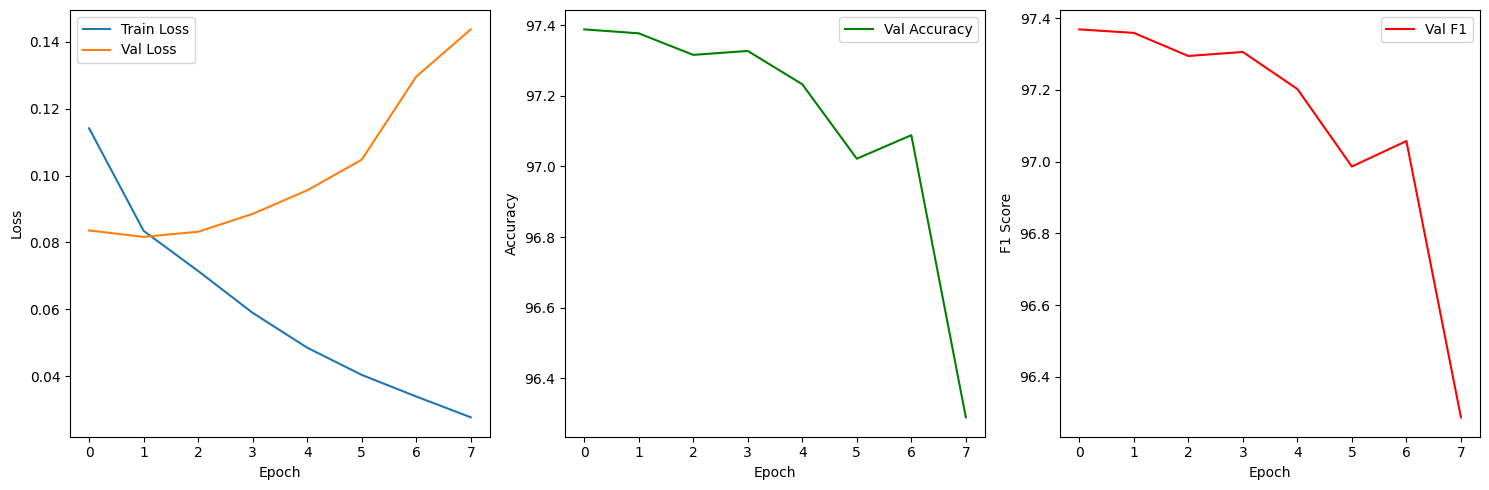

Best Validation Accuracy: 97.39%


In [39]:
# -*- coding: utf-8 -*-
import os
import re
import random
import jieba
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from typing import List

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

NUM_EPOCHS = 12
BATCH_SIZE = 128
MAX_SEQ_LEN = 200
MAX_VOCAB = 80000
EMBED_DIM = 300
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.2
PATIENCE = 7
LR = 1e-3

def clean_text(text: str) -> str:
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def chinese_tokenizer(text: str):
    return list(jieba.cut(clean_text(text), cut_all=False))

def build_vocab(texts: List[str], max_vocab_size: int = MAX_VOCAB) -> dict:
    freq = Counter()
    for t in texts:
        tokens = chinese_tokenizer(t)
        freq.update(tokens)
    vocab = {'<PAD>':0, '<unk>':1}
    for w, _ in freq.most_common(max_vocab_size-2):
        vocab[w] = len(vocab)
    print("Vocabulary size:", len(vocab))
    return vocab

def text_pipeline(text: str, vocab: dict, max_len: int = MAX_SEQ_LEN):
    tokens = chinese_tokenizer(text)[:max_len]
    ids = [vocab.get(tok, vocab['<unk>']) for tok in tokens]
    if len(ids) < max_len:
        ids += [vocab['<PAD>']]*(max_len-len(ids))
    return ids, len(tokens)

def label_pipeline(label):
    return 1 if label == 1 else 0

class SentimentDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], vocab: dict):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_ids, actual_len = text_pipeline(self.texts[idx], self.vocab)
        text_ids = torch.tensor(text_ids, dtype=torch.long)
        label = torch.tensor(label_pipeline(self.labels[idx]), dtype=torch.float)
        length = torch.tensor(actual_len, dtype=torch.long)
        return text_ids, label, length

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, lstm_out, lengths):
        scores = self.proj(lstm_out).squeeze(-1)
        max_len = lstm_out.size(1)
        mask = torch.arange(max_len, device=DEVICE)[None,:] >= lengths[:,None]
        scores.masked_fill_(mask, -1e9)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        context = torch.sum(lstm_out * weights, dim=1)
        return context, weights

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size: int, embedding_matrix: np.ndarray=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBED_DIM, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data[:embedding_matrix.shape[0]] = torch.tensor(embedding_matrix, dtype=torch.float)
        self.embedding.weight.requires_grad = True

        self.lstm = nn.LSTM(EMBED_DIM, HIDDEN_DIM, N_LAYERS,
                            batch_first=True, dropout=DROPOUT if N_LAYERS>1 else 0,
                            bidirectional=True)

        self.attention = Attention(HIDDEN_DIM)

        self.classifier = nn.Sequential(
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM),
            nn.ReLU(),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(DROPOUT/2),
            nn.Linear(64, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        context, attn_weights = self.attention(lstm_out, lengths)
        logits = self.classifier(context).squeeze(1)
        return logits

def train_model(texts, labels, embedding_matrix=None):
    vocab = build_vocab(texts)

    X_train, X_val, y_train, y_val = train_test_split(
        texts, labels, test_size=0.15, random_state=SEED, stratify=labels
    )

    train_dataset = SentimentDataset(X_train, y_train, vocab)
    val_dataset = SentimentDataset(X_val, y_val, vocab)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=True)

    model = RNNClassifier(len(vocab), embedding_matrix).to(DEVICE)

    pos_weight = torch.tensor([1.0]).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    history = {"train_loss":[], "val_loss":[], "val_acc":[], "val_f1":[]}
    best_val_acc = 0
    counter = 0

    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        running_loss = 0
        train_correct = 0
        train_total = 0

        for data, target, lengths in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}"):
            data, target, lengths = data.to(DEVICE), target.to(DEVICE), lengths.to(DEVICE)
            optimizer.zero_grad()
            logits = model(data, lengths)
            loss = criterion(logits, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == target).sum().item()
            train_total += target.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target, lengths in val_loader:
                data, target, lengths = data.to(DEVICE), target.to(DEVICE), lengths.to(DEVICE)
                logits = model(data, lengths)
                loss = criterion(logits, target)
                val_loss += loss.item()

                preds = (torch.sigmoid(logits) > 0.5).float()
                correct += (preds == target).sum().item()
                total += target.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        from sklearn.metrics import f1_score
        val_f1 = f1_score(all_targets, all_preds, average='binary') * 100

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'vocab': vocab,
                'val_acc': val_acc
            }, "best_model.pth")
            counter = 0
            print(f"Saved best model with val_acc: {val_acc:.2f}%")
        else:
            counter += 1
            if counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(history["val_acc"], label="Val Accuracy", color='green')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(history["val_f1"], label="Val F1", color='red')
    plt.xlabel("Epoch"); plt.ylabel("F1 Score"); plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    return model, vocab

if __name__=="__main__":
    jieba.initialize()

    file_candidates = [f for f in os.listdir(".") if f.lower() in ("train.tsv","train.csv","weibo_senti_100k.csv")]
    if not file_candidates:
        raise FileNotFoundError("Dataset not found.")

    file_path = file_candidates[0]
    df = pd.read_csv(file_path, sep="\t" if file_path.endswith(".tsv") else ",")

    if 'text_a' in df.columns:
        texts = df['text_a'].astype(str).tolist()
    elif 'review' in df.columns:
        texts = df['review'].astype(str).tolist()
    else:
        texts = df.iloc[:, 0].astype(str).tolist()

    labels = df['label'].astype(int).tolist()

    print(f"Dataset loaded: {len(texts)} samples")
    print(f"Label distribution: {Counter(labels)}")

    embedding_matrix = None

    model, vocab = train_model(texts, labels, embedding_matrix)

---

We can try predicting some custom sentences to see the results.

In [40]:
# Define a function for sentiment prediction
def predict_sentiment(sentence, model, vocab, device):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the sentence and convert tokens to indices
    tokens = [vocab.get(token, vocab["<unk>"]) for token in jieba.cut(sentence)]
    text_tensor = torch.tensor(tokens, dtype=torch.int64).unsqueeze(0).to(device)  # Add batch dimension
    length_tensor = torch.tensor([len(tokens)]).to(device)  # Create a length tensor

    # Forward pass
    with torch.no_grad():
        prediction = model(text_tensor, length_tensor).item()

    # Output the prediction result
    return "pos" if prediction > 0.5 else "neg"

# Example usage
test_sentence = "这部电影非常精彩，值得一看！"  # Test sentence
result = predict_sentiment(test_sentence, model, vocab, device)
print(f"Sentiment classification result for '{test_sentence}': {result}")

test_sentence = "太差了吧！！！"  # Another test sentence
result = predict_sentiment(test_sentence, model, vocab, device)
print(f"Sentiment classification result for '{test_sentence}': {result}")

test_sentence = """北京师范大学-香港浸会大学联合国际学院（中文简称“北师港浸大”，英文简称“UIC”）成立于2005年，
是首家中国内地与香港高等教育界合作创办的大学，也是内地第一所创新的博雅型大学，位于粤港澳大湾区的珠海市。
秉承博雅教育办学理念，北师港浸大致力于为内地高等教育多元化发展开辟一条新路，为国家和社会培养专业知识与综合素质双修、
家国情怀与国际视野兼具的新时代学子。"""  # Long text for testing
result = predict_sentiment(test_sentence, model, vocab, device)
print(f"Sentiment classification result for '{test_sentence}': {result}")



Sentiment classification result for '这部电影非常精彩，值得一看！': neg
Sentiment classification result for '太差了吧！！！': neg
Sentiment classification result for '北京师范大学-香港浸会大学联合国际学院（中文简称“北师港浸大”，英文简称“UIC”）成立于2005年，
是首家中国内地与香港高等教育界合作创办的大学，也是内地第一所创新的博雅型大学，位于粤港澳大湾区的珠海市。
秉承博雅教育办学理念，北师港浸大致力于为内地高等教育多元化发展开辟一条新路，为国家和社会培养专业知识与综合素质双修、
家国情怀与国际视野兼具的新时代学子。': neg
